In [296]:
import pandas as pd
import csv
import numpy as np
import itertools
from scipy import sparse

from tqdm.notebook import tqdm, trange

In [297]:
edges_file_path = "./Gowalla_edges.txt"

edges = np.loadtxt('Gowalla_edges.txt',dtype=int)

In [298]:
print(edges.shape)

(1900654, 2)


In [299]:
unique_users_number = len(np.unique(edges))
print("Uniq users number: " + str(unique_users_number))

Uniq users number: 196591


In [300]:
row = []
col = []
data = []

print(edges.shape[0])

for edge in edges:
    row.append(edge[0])
    col.append(edge[1])
    data.append(1)

1900654


In [301]:
# check if users indexes are sequential without spaces
print(edges.min())
print(edges.max())

0
196590


In [302]:
# s(i,i) - self-similarity values
for i in range(unique_users_number):
    row.append(i)
    col.append(i)
    data.append(-1.5)

In [303]:
# merge row, col and data into coo matrix (which is a similarity matrix in this case)
#s = sparse.coo_matrix((data, (row, col)), dtype=np.int8)
s = sparse.coo_matrix((data, (row, col)))

print(s.shape)
# print(users_conn)

(196591, 196591)


In [304]:
def upd_responsibility(s, a_data, r_data):
    data = s.data + a_data
    row_idxs = s.row
    col_idxs = s.col
    
    # max in row
    row_max1 = np.repeat(-np.inf, s.shape[0])
    # column index of the maximum in row i
    row_max1_col_idx = np.repeat(None, s.shape[0])
    # max in row for cases when k' == k
    row_max2 = np.repeat(-np.inf, s.shape[0])
    
    for idx,pair_ik in enumerate(zip(row_idxs, col_idxs)):
        if row_max1[pair_ik[0]] < data[idx]:
            row_max2[pair_ik[0]] = row_max1[pair_ik[0]]
            row_max1[pair_ik[0]] = data[idx]
            # save column index of the cell with max value in row i 
            row_max1_col_idx[pair_ik[0]] = pair_ik[1]
        elif row_max2[pair_ik[0]] < data[idx]:
            row_max2[pair_ik[0]] = data[idx]
    
    #r[i,k] = s[i,k] - max(a[i,k'] + s[i,k']){k' != k}
    r_new = s.data.copy()
    for idx,pair_ik in enumerate(zip(row_idxs, col_idxs)):
        # if k' != k
        if row_max1_col_idx[pair_ik[0]] != pair_ik[1]:
            r_new[idx] -= row_max1[pair_ik[0]]
        # if k' == k
        else:
            # check for case when user i had only one connection so
            #  row_max2[i] was linked to -inf 
            if row_max2[pair_ik[0]] != -np.inf:
                r_new[idx] -= row_max2[pair_ik[0]]
            # else: r_new[idx] -= 0
    return r_new


def upd_availability(s, a_data, r_data):
    r_copy = r_data.copy()
    
    for i in range(0,len(edges)):
        if r_copy[i] < 0:
            r_copy[i] = 0
    
    positive_r = np.repeat(0, s.shape[0])
    
    for idx, pair in enumerate(zip(s.row, s.col)):
        positive_r[pair[1]] += r_copy[idx]
    
    for idx, pair in enumerate(zip(s.row, s.col)):
        a_data[idx] = positive_r[pair[1]] - r_copy[idx]
    
    #count min
    for i in range(0,len(edges)):
        a_data[i] = np.min([0, a_data[i]])
    
    return a_data


def calc_criterion(r, a):
    return r + a

In [305]:
def get_exemplars(c_data, s, transitivity_param = 5):
    # stores max values for comparison
    temp = np.repeat(-np.inf, s.shape[0])
    
    exemplars = dict()
    
    # for each user get exemplar
    for idx, pair in enumerate(zip(s.row, s.col)):
        # for each user i find user j with max value from criterion matrix
        if c_data[idx] > temp[pair[0]]:
            temp[pair[0]] = c_data[idx]
            exemplars[pair[0]] = pair[1]
    
    for i in range(transitivity_param):        
        for exempl_a in exemplars.keys(): 
            #exemplar b for user a
            exempl_b = exemplars[exempl_a]
            #if b is not exemplar for b (self-exemplar)
            if exemplars[exempl_b] != exempl_b:
                #find exemplar for b, it is c
                exempl_с = exemplars[exempl_b]
                #update main: put exemplar c as exemplae for a
                exemplars[exempl_a] = exempl_с
    
    return exemplars

In [306]:
def affinity_propagation(s, number_of_iterations=1):
    # operate with only (i,j) data, as sparse matrixes are too big
    a_data = np.repeat(0, s.data.shape[0])
    r_data = np.repeat(0, s.data.shape[0])
    
    print(s.shape)
    print(a_data.shape)
    print(r_data.shape)
    
    for iter in tqdm(range(number_of_iterations), desc='Iter number'):
        print("Update R")
        r_data = upd_responsibility(s, a_data, r_data)
        print("Update A")
        a_data = upd_availability(s, a_data, r_data)
    
    print("Calculate C")
    c_data = calc_criterion(r_data, a_data)
    
    return get_exemplars(c_data, s)
    

In [307]:
# {user i -> user j with which user i is connected}
result = affinity_propagation(s, number_of_iterations=10)

(196591, 196591)
(2097245,)
(2097245,)


Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A
Update R
Update A

Calculate C


In [308]:
#Amount of clusters
clusters=sorted(list(set(result.values())))
print("Clusters amount:", len(clusters))

Clusters amount: 17955


In [309]:
import matplotlib.pyplot as plt

Max cluster size: 16100
Min cluster size: 1


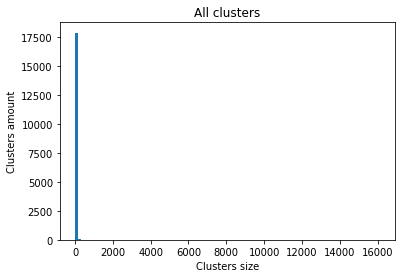

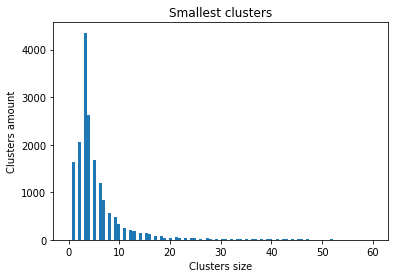

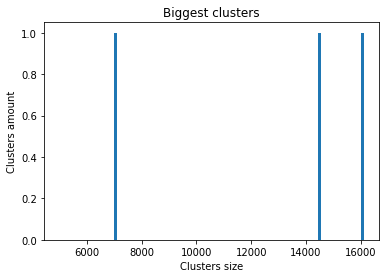

In [324]:
# {cluster -> users number}
cluster_size = dict()
for exemplar in result.values():
    if exemplar not in cluster_size:
        cluster_size[exemplar] = 1
    else:
        cluster_size[exemplar] += 1
print("Max cluster size:", max(cluster_size.values()))
print("Min cluster size:", min(cluster_size.values()))

#plot all
plt.hist(cluster_size.values(), bins=100)
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("All clusters")
plt.show()

#plot the smallest
plt.hist(cluster_size.values(), bins=100, range=(0, 60))
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Smallest clusters")
plt.show()


#plot the biggest
plt.hist(cluster_size.values(), bins=100, range=(5000, 16101))
plt.xlabel("Clusters size")
plt.ylabel("Clusters amount")
plt.title("Biggest clusters")
plt.show()

In [323]:
import pandas as pd

df_checkins = pd.read_csv("./Gowalla_totalCheckins.txt", sep="	", header=None)[[0, 4]]
df_checkins.columns = ["user_id", "location_id"]
print(len(df_checkins))
df_checkins.head()


6442892


,user_id,location_id
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878


In [312]:
clusters=(list(result.values()))
print(len(clusters))
df_clusters = pd.DataFrame(clusters)
df_clusters = df_clusters.reset_index()
df_clusters.columns = ["user_id", "cluster_id"]
print(len(df_clusters))
df_clusters.head()

196591
196591


,user_id,cluster_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [313]:
df = pd.merge(df_checkins, df_clusters, on=['user_id'])
print(len(df))
df.head()

6442892


,user_id,location_id,cluster_id
0,0,22847,0
1,0,420315,0
2,0,316637,0
3,0,16516,0
4,0,5535878,0


In [314]:
users_with_location = np.unique(df_checkins.user_id)
print(len(users_with_location))

107092


In [315]:
from sklearn.model_selection import train_test_split

#split data (user checkins) into test and train batches with shuffling
train_users, test_users = train_test_split(users_with_location, test_size=0.1, shuffle=True)
print(len(train_users))
print(len(test_users))

96382
10710


In [316]:
# train checkins (from train users only)
train_checkins = df.loc[df.user_id.isin(train_users)]
print(len(train_checkins))

# test checkins (from test users only)
test_checkins = df.loc[df.user_id.isin(test_users)]
print(len(test_checkins))

test_checkins.head()

5825761
617131


,user_id,location_id,cluster_id
2337,4,14608,4
2338,4,640452,4
2339,4,166197,4
2340,4,26645,4
2341,4,102499,4


In [320]:
# {location_id -> presense count in data}
counted_locations = train_checkins.groupby(by='location_id')['location_id'].count()
# sort descending
sorted_locations = counted_locations.sort_values(ascending = False)
print(sorted_locations)
# get 10 most popular locations (global train top)
top10_locations = list(sorted_locations.iloc[:10].index)
print(top10_locations)

location_id
55033      5239
19542      5140
9410       4292
10259      3739
58725      3158
           ... 
4425459       1
3899315       1
528147        1
1217402       1
5977211       1
Name: location_id, Length: 1218004, dtype: int64
[55033, 19542, 9410, 10259, 58725, 9246, 10190, 23256, 14470, 9241]


In [318]:
# amount of times user in this cluster check-ins in this location 
train_loc_ratings = train_checkins.groupby(by = ["cluster_id", "location_id"])["location_id"].count()

train_loc_ratings = train_loc_ratings.reset_index(name='rating').sort_values(by = ["cluster_id", "rating"], ascending = False)
train_loc_ratings.head()

,cluster_id,location_id,rating
3105934,196539,103606,11
3105940,196539,271694,5
3105935,196539,124683,1
3105936,196539,128331,1
3105937,196539,130147,1


In [321]:
def correct_prec_numb(top_data, pred_data, k = 10):
    # calc number of correct precisions
    return len(set(top_data[:k]).intersection(set(pred_data)))

tp_base = 0
tp_cluster = 0
denom = len(test_users)*10

for user in tqdm(test_users, desc='User'):
    cluster = clusters[user]
    user_locations = test_checkins.loc[test_checkins.user_id == user, "location_id"].values
    
    if cluster in train_loc_ratings.cluster_id:    
        cluster_top = train_loc_ratings.loc[train_loc_ratings.cluster_id == cluster, "location_id"].values
        tp_cluster += correct_prec_numb(cluster_top, user_locations)

    tp_base += correct_prec_numb(top10_locations, user_locations)

base_precision = tp_base/denom
cluster_precision = tp_cluster/denom

print("Base precision (train data top): ", base_precision)
print("Cluster precision (user cluster top): ", cluster_precision)


Base precision (train data top):  0.016479925303454716
Cluster precision (user cluster top):  0.03784313725490196
